In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import edunn as nn
from edunn import utils

In [3]:
np.set_printoptions(threshold=sys.maxsize)

# Gaussian Error Linear Unit

GELU es una función de activación que se utiliza en las capas ocultas de las redes neuronales. Se utiliza para introducir la no linealidad en los modelos de redes neuronales y ayuda a decidir qué neuronas deben activarse. 

GELU combina las ventajas de otras funciones de activación populares como ReLU y ELU. Proporciona una saturación suave tanto para los valores positivos como para los negativos, lo que puede ayudar a mitigar el problema del desvanecimiento del gradiente.

## Método Forward

Existen distintas formas de expresar tal función, una de ellas es utilizando la función de distribución acumulativa (CDF) y la [función de error](https://en.wikipedia.org/wiki/Error_function):

$$ \text{GELU} = x \cdot \text{CDF}(x) = x \cdot \frac{1+\text{erf}\big(\frac{1}{\sqrt{2}}\big)}{2} $$

Esto se debe a que la `CDF` puede ser expresada utilizando la `erf`, donde se escala la función lineal `x` con la `CDF`. Esta versión de GELU es computacionalmente más eficiente y es la que se utiliza en la biblioteca de aprendizaje profundo de PyTorch.

<center>
<img src="img/gelu.png" width="25%" style="display:inline-block">
</center>

> NOTA: actualmente la función `erf` no es encuentra implementada en `numpy`, puedes tomarte el tiempo de implementarla numéricamente o utilizar la implementación dada por `from scipy.special import erf`.

## Método Backward

Su cálculo es más sencillo de lo que parece, ya que en el mismo no utilizaremos la expresión dependiente de la `erf`, sino la que depende expresamente de `CDF`.

$$
\begin{aligned}
(\text{x} \cdot \text{CDF}(\text{x}))' &= \text{x}' \cdot \text{CDF}(\text{x}) + \text{x} \cdot \text{CDF}'(\text{x}) \\
&= \text{CDF}(\text{x}) + \text{x} \cdot \text{PDF}(\text{x})
\end{aligned}
$$

Esto se debe al teorema fundamental del cálculo, donde por definición: 

- Derivar la CDF te da la PDF: $\text{PDF}(x) = \frac{d}{dx} \text{CDF}(x)$
- Integrar la PDF te da la CDF: $\text{CDF}(x) = \int_{-\infty}^{x} \text{PDF}(t) dt$

La `PDF` que utilizaremos es la de la distribución normal o Gaussiana. Nuevamente, `numpy` no provee su cálculo en relación a los valores de un vector de entrada, por ello deberás implentar la función `normal_pdf` en el archivo `activations.py`.

Esta es la fórmula para la función de densidad de probabilidad (PDF) de una distribución normal:

$$
f(x, \mu=0, \sigma=1) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

donde $x$ es la variable aleatoria, $\mu$ es la media de la distribución y $\sigma$ es la desviación estándar de la distribución. 

<!-- La PDF (Función de Densidad de Probabilidad) da la probabilidad de que una variable aleatoria tome un valor específico, mientras que la CDF (Función de Distribución Acumulativa) da la probabilidad de que una variable aleatoria tome un valor menor o igual a un valor dado. -->

<!-- 1. **PDF (Función de Densidad de Probabilidad)**: Es una función que describe la probabilidad relativa de que una variable aleatoria tome un valor dado. La probabilidad de que la variable aleatoria caiga dentro de un rango particular se dada por el área bajo la gráfica de la función de densidad en ese intervalo.

2. **CDF (Función de Distribución Acumulativa)**: Es una función que indica la probabilidad de que una variable aleatoria sea menor o igual a un valor dado. Es la integral de la PDF hasta ese valor.

- La PDF puede tomar valores mayores a 1, mientras que la CDF nunca puede tomar valores mayores a 1. -->

In [9]:
np.random.seed(123)

din=10
batch_size=2

x = np.random.rand(batch_size,din)

layer=nn.GELU()

In [10]:
x

array([[0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
        0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752],
       [0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
        0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759]])

In [11]:
y = layer.forward(x)
y, y.shape

(array([[0.52718014, 0.17529305, 0.13378119, 0.39104263, 0.54972753,
         0.28089666, 0.82055193, 0.51586465, 0.32930251, 0.25586229],
        [0.21766674, 0.5591916 , 0.29363036, 0.03125892, 0.26060006,
         0.5680656 , 0.10445855, 0.09994393, 0.37340507, 0.37364999]]),
 (2, 10))

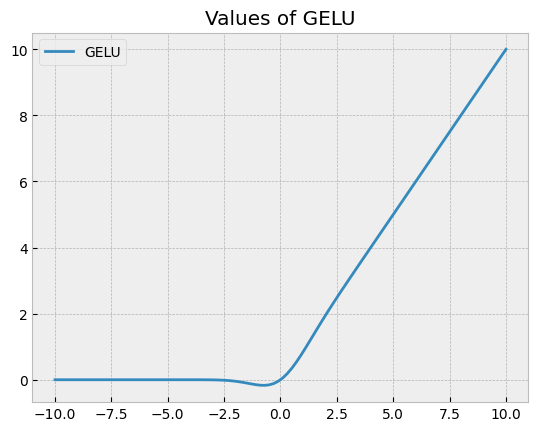

In [7]:
# plot values
nn.plot.plot_activation_function(layer)

In [12]:
# Define el gradiente de la salida
g = np.random.rand(*y.shape)

# Propaga el gradiente hacia atrás a través de la convolución
layer_grad = layer.backward(g)
layer_grad

(array([[0.61850574, 0.61344992, 0.49113149, 0.54883612, 0.71207494,
         0.26425595, 0.39019851, 0.22127225, 0.25130995, 0.50312207],
        [0.07030801, 0.42935829, 0.35694231, 0.27032201, 0.34126187,
         0.31037929, 0.27457151, 0.57048588, 0.83709384, 0.44501168]]),
 {})

In [13]:
import torch
import torch.nn as tnn

x = torch.from_numpy(x).to(torch.float)

# Definimos la capa GELU
gelu = tnn.GELU()

x.requires_grad = True

y_torch = gelu(x)
y_torch

tensor([[0.5272, 0.1753, 0.1338, 0.3910, 0.5497, 0.2809, 0.8206, 0.5159, 0.3293,
         0.2559],
        [0.2177, 0.5592, 0.2936, 0.0313, 0.2606, 0.5681, 0.1045, 0.0999, 0.3734,
         0.3736]], grad_fn=<GeluBackward0>)

In [14]:
utils.check_same(y_torch.detach().numpy(),y,tol=1e-5)

SUCCESS :) Arrays are equal (tolerance 1e-05)


In [15]:
# Define el gradiente de la salida
g = torch.from_numpy(g).to(torch.double)

# Propaga el gradiente hacia atrás
x.grad = None  # Limpiamos los gradientes existentes
y_torch.backward(g)

# Imprime el gradiente de la imagen de entrada
print("Gradiente de la entrada (δE/δx):")
print(x.grad, x.grad.shape)

Gradiente de la entrada (δE/δx):
tensor([[0.6185, 0.6134, 0.4911, 0.5488, 0.7121, 0.2643, 0.3902, 0.2213, 0.2513,
         0.5031],
        [0.0703, 0.4294, 0.3569, 0.2703, 0.3413, 0.3104, 0.2746, 0.5705, 0.8371,
         0.4450]]) torch.Size([2, 10])


In [16]:
utils.check_same(x.grad.numpy(),layer_grad[0],tol=1e-5)

SUCCESS :) Arrays are equal (tolerance 1e-05)


GELU_2 layer:
 ERROR 
δEδx
 Relative error (max):0.20005 (tolerance: 1e-07)
######################## Details: ######################## 
 Input x:
[[ 0.97873601  2.23814334]
 [-1.29408532 -1.03878821]
 [ 1.74371223 -0.79806274]
 [ 0.02968323  1.06931597]
 [ 0.89070639  1.75488618]]
 Input δEδy:
[[ 1.49564414  1.06939267]
 [-0.77270871  0.79486267]
 [ 0.31427199 -1.32626546]
 [ 1.41729905  0.80723653]
 [ 0.04549008 -0.23309206]]
 δEδx (numerical, automatic):
[[ 2.41846565  1.70089259]
 [ 0.14564291 -0.10988296]
 [ 0.52397007  0.03806736]
 [ 1.11330155  1.32996866]
 [ 0.07181332 -0.38826507]]
 δEδx (analytic, your implementation):
[[ 1.61231236  1.13392787]
 [ 0.09709505 -0.07325446]
 [ 0.34931323  0.02537562]
 [ 0.74220668  0.88664655]
 [ 0.04787562 -0.25884327]]
##########################################################



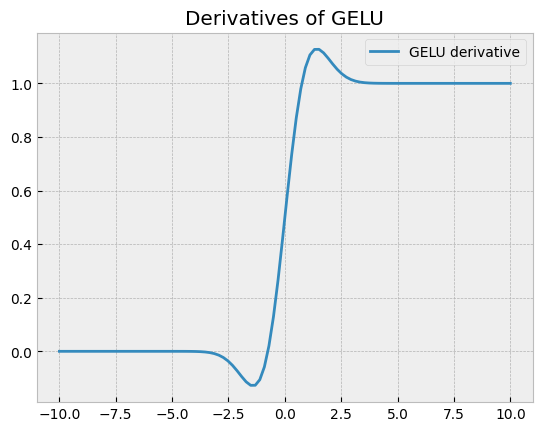

In [17]:
from edunn.utils import check_gradient


# Cantidad de ejemplos aleatorios y tamaño de los mismo gpara generar 
# muestras de x y verificar las derivadas
samples = 100
input_shape=(5,2)

# Verificar derivadas de una función GELU
layer=nn.GELU()
check_gradient.common_layer(layer,input_shape,samples=samples)

nn.plot.plot_activation_function(nn.GELU(),backward=True)